In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from arch import arch_model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen


In [2]:
# ============================
# PERMUTATION ENTROPY FUNCTIONS
# ============================

def permutation_entropy(time_series, m=3, delay=1):
   
    n = len(time_series)
    if n < m * delay:
        return np.nan
    perms = np.array(list(itertools.permutations(range(m))))
    c = np.zeros(len(perms))
    for i in range(n - delay * (m - 1)):
        sorted_index = np.argsort(time_series[i: i + delay * m: delay])
        for j, p in enumerate(perms):
            if np.array_equal(sorted_index, p):
                c[j] += 1
    c = c[c > 0]
    p = c / np.sum(c)
    pe = -np.sum(p * np.log(p))
    return pe

def rolling_pe(series, window, m=3, delay=1):
    return series.rolling(window).apply(lambda x: permutation_entropy(x, m, delay), raw=False)

# ============================
# HURST EXPONENT (R/S method)
# ============================

def hurst_exponent(series):
    N = len(series)
    if N < 20:
        return np.nan
    Y = np.cumsum(series - np.mean(series))
    R = np.max(Y) - np.min(Y)
    S = np.std(series)
    if S == 0:
        return np.nan
    return np.log(R/S) / np.log(N)

def rolling_hurst(series, window_size=30):
    h_vals = []
    for i in range(len(series)):
        if i < window_size:
            h_vals.append(np.nan)
        else:
            window_data = series.iloc[i-window_size:i]
            h = hurst_exponent(window_data)
            h_vals.append(h)
    return pd.Series(h_vals, index=series.index)

# ============================
# KMEANS CLUSTERING FUNCTION
# ============================

def kmeans_cluster(series, n_clusters=3):
    s = series.dropna()
    if s.empty:
        return pd.Series(np.nan, index=series.index, name=(series.name or "Unnamed") + '_cluster')
    scaler = StandardScaler()
    values = scaler.fit_transform(s.values.reshape(-1, 1))
    km = KMeans(n_clusters=n_clusters, random_state=42)
    labels = pd.Series(km.fit_predict(values), index=s.index, name=(series.name or "Unnamed") + '_cluster')
    return labels

def reorder_clusters(series, cluster_labels):
    df_temp = pd.DataFrame({'value': series.loc[cluster_labels.index], 'cluster': cluster_labels})
    cluster_means = df_temp.groupby('cluster')['value'].mean().sort_values()
    mapping = {old: new for new, old in enumerate(cluster_means.index)}
    return cluster_labels.map(mapping)

In [3]:
# ============================
# MAIN CODE
# ============================

# Load VIX data
file_path = r'C:\Users\npwol\OneDrive\Desktop\CVR (Classifying VIX Regimes)\VIX_History.csv'
df = pd.read_csv(file_path)

# Parse the DATE column and sort; set as index
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
df.sort_values('DATE', inplace=True)
df.set_index('DATE', inplace=True)

# Compute RETURN as percentage change on CLOSE
df['RETURN'] = df['CLOSE'].pct_change() * 100

# -----------------------------
# GARCH MODELS
# -----------------------------
# Fit GARCH on RETURN
ret_series = df['RETURN'].dropna()
am_ret = arch_model(ret_series, vol='Garch', p=1, q=1, rescale=False)
res_ret = am_ret.fit(disp='off')
df.loc[res_ret.conditional_volatility.index, 'RETURN_GARCH'] = res_ret.conditional_volatility

# Log returns for CLOSE
close_ret = np.log(df['CLOSE']).diff().dropna()
am_close = arch_model(close_ret, vol='Garch', p=1, q=1, rescale=False)
res_close = am_close.fit(disp='off')
df.loc[res_close.conditional_volatility.index, 'CLOSE_GARCH'] = res_close.conditional_volatility

# -----------------------------
# ROLLING PERMUTATION ENTROPY (PE)
# -----------------------------
window = 30
df['RETURN_PE'] = rolling_pe(df['RETURN'], window=window)
df['CLOSE_PE'] = rolling_pe(df['CLOSE'], window=window)

# -----------------------------
# ROLLING HURST EXPONENT (HE) using R/S method
# -----------------------------
df['RETURN_HE'] = rolling_hurst(df['RETURN'], window_size=30)
df['CLOSE_HE'] = rolling_hurst(df['CLOSE'], window_size=30)



In [4]:
# =============================================================================
# KMEANS CLUSTERING FOR EACH FEATURE
# =============================================================================

# For raw VIX CLOSE
close_clusters = kmeans_cluster(df['CLOSE'], n_clusters=3)
df.loc[close_clusters.dropna().index, 'KMEANS_BIN_CLOSE'] = reorder_clusters(df['CLOSE'], close_clusters)

# For raw VIX RETURN
return_clusters = kmeans_cluster(df['RETURN'], n_clusters=3)
df.loc[return_clusters.dropna().index, 'KMEANS_RETURN_BIN'] = reorder_clusters(df['RETURN'], return_clusters)

# For RETURN_GARCH
return_garch_clusters = kmeans_cluster(df['RETURN_GARCH'], n_clusters=3)
df.loc[return_garch_clusters.dropna().index, 'KMEANS_RETURN_GARCH'] = return_garch_clusters
df.loc[return_garch_clusters.dropna().index, 'KMEANS_RETURN_GARCH_BIN'] = reorder_clusters(df['RETURN_GARCH'], return_garch_clusters)

# For CLOSE_GARCH
close_garch_clusters = kmeans_cluster(df['CLOSE_GARCH'], n_clusters=3)
df.loc[close_garch_clusters.dropna().index, 'KMEANS_CLOSE_GARCH'] = close_garch_clusters
df.loc[close_garch_clusters.dropna().index, 'KMEANS_CLOSE_GARCH_BIN'] = reorder_clusters(df['CLOSE_GARCH'], close_garch_clusters)

# For RETURN_PE
return_pe_clusters = kmeans_cluster(df['RETURN_PE'], n_clusters=3)
df.loc[return_pe_clusters.dropna().index, 'KMEANS_RETURN_PE'] = return_pe_clusters
df.loc[return_pe_clusters.dropna().index, 'KMEANS_RETURN_PE_BIN'] = reorder_clusters(df['RETURN_PE'], return_pe_clusters)

# For CLOSE_PE
close_pe_clusters = kmeans_cluster(df['CLOSE_PE'], n_clusters=3)
df.loc[close_pe_clusters.dropna().index, 'KMEANS_CLOSE_PE'] = close_pe_clusters
df.loc[close_pe_clusters.dropna().index, 'KMEANS_CLOSE_PE_BIN'] = reorder_clusters(df['CLOSE_PE'], close_pe_clusters)

# For RETURN_HE
return_he_clusters = kmeans_cluster(df['RETURN_HE'], n_clusters=3)
df.loc[return_he_clusters.dropna().index, 'KMEANS_RETURN_HE'] = return_he_clusters
df.loc[return_he_clusters.dropna().index, 'KMEANS_RETURN_HE_BIN'] = reorder_clusters(df['RETURN_HE'], return_he_clusters)

# For CLOSE_HE
close_he_clusters = kmeans_cluster(df['CLOSE_HE'], n_clusters=3)
df.loc[close_he_clusters.dropna().index, 'KMEANS_CLOSE_HE'] = close_he_clusters
df.loc[close_he_clusters.dropna().index, 'KMEANS_CLOSE_HE_BIN'] = reorder_clusters(df['CLOSE_HE'], close_he_clusters)


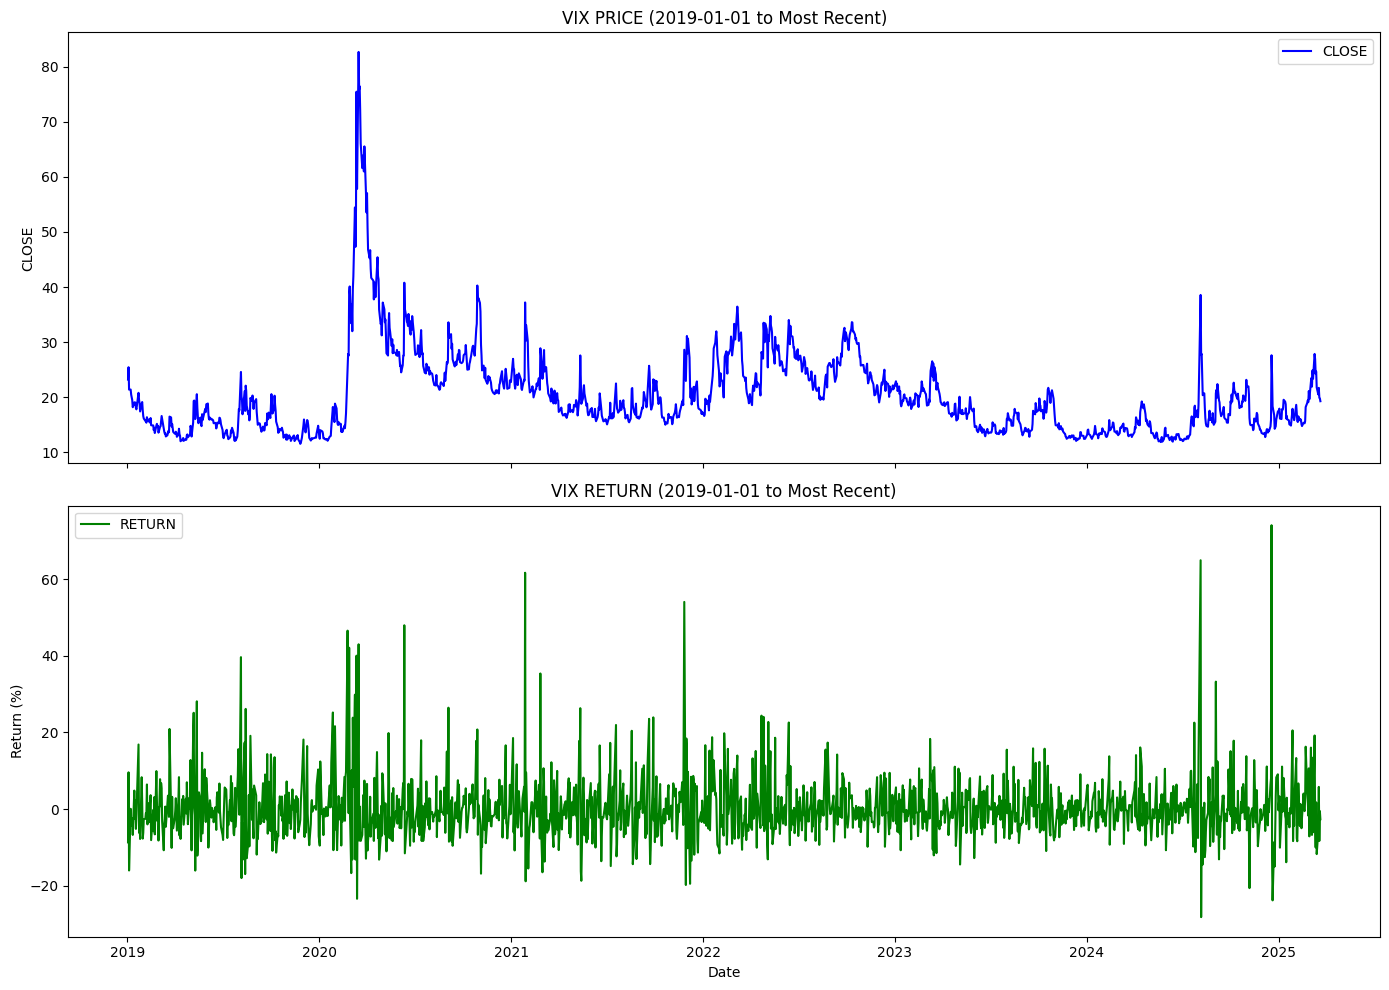

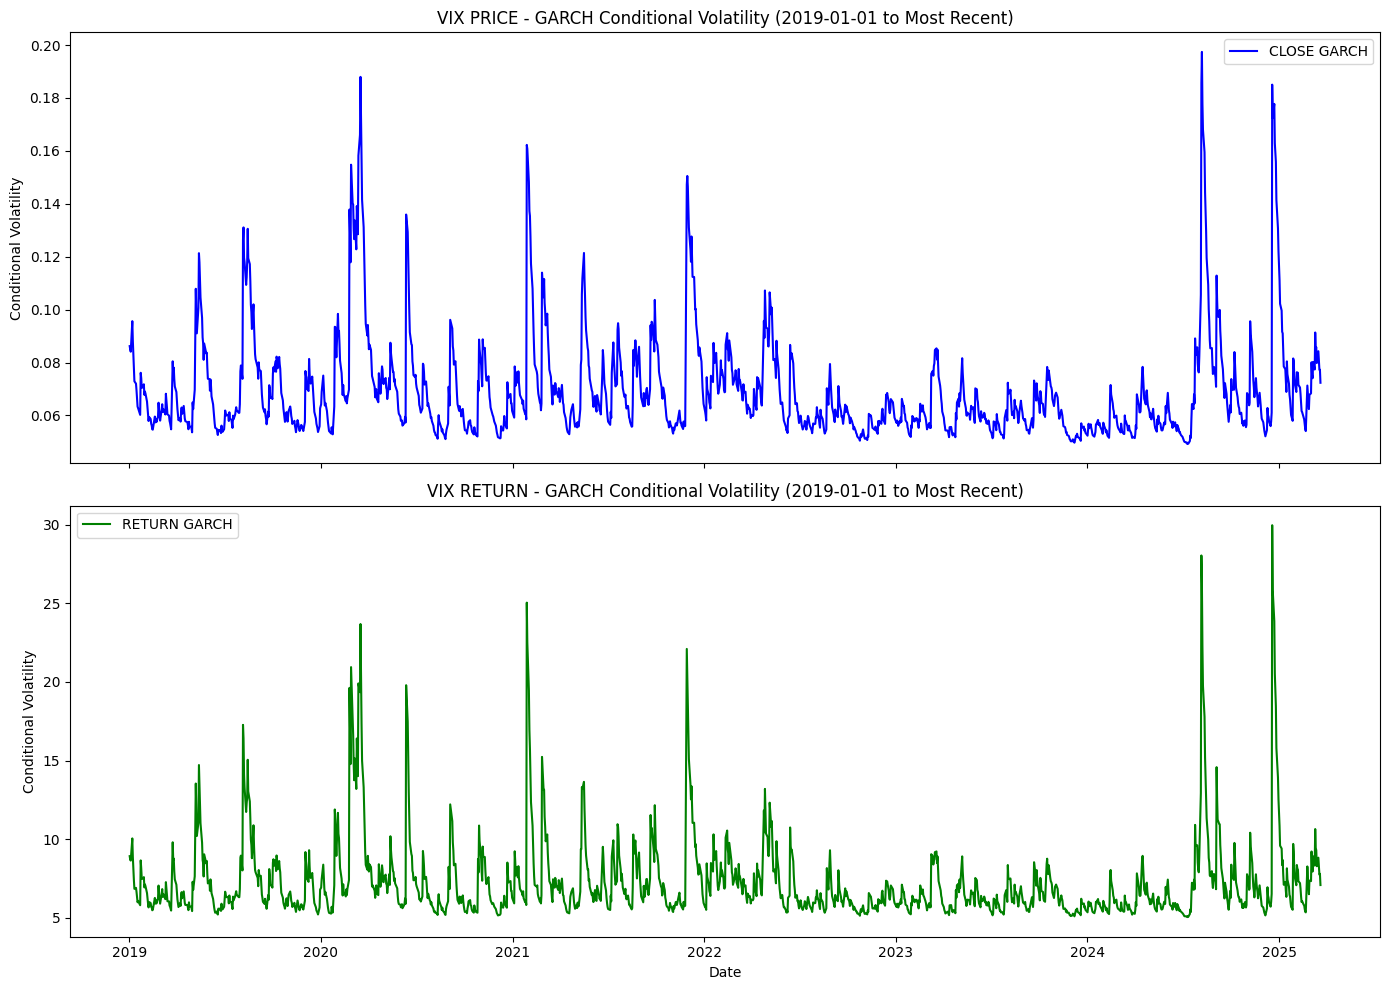

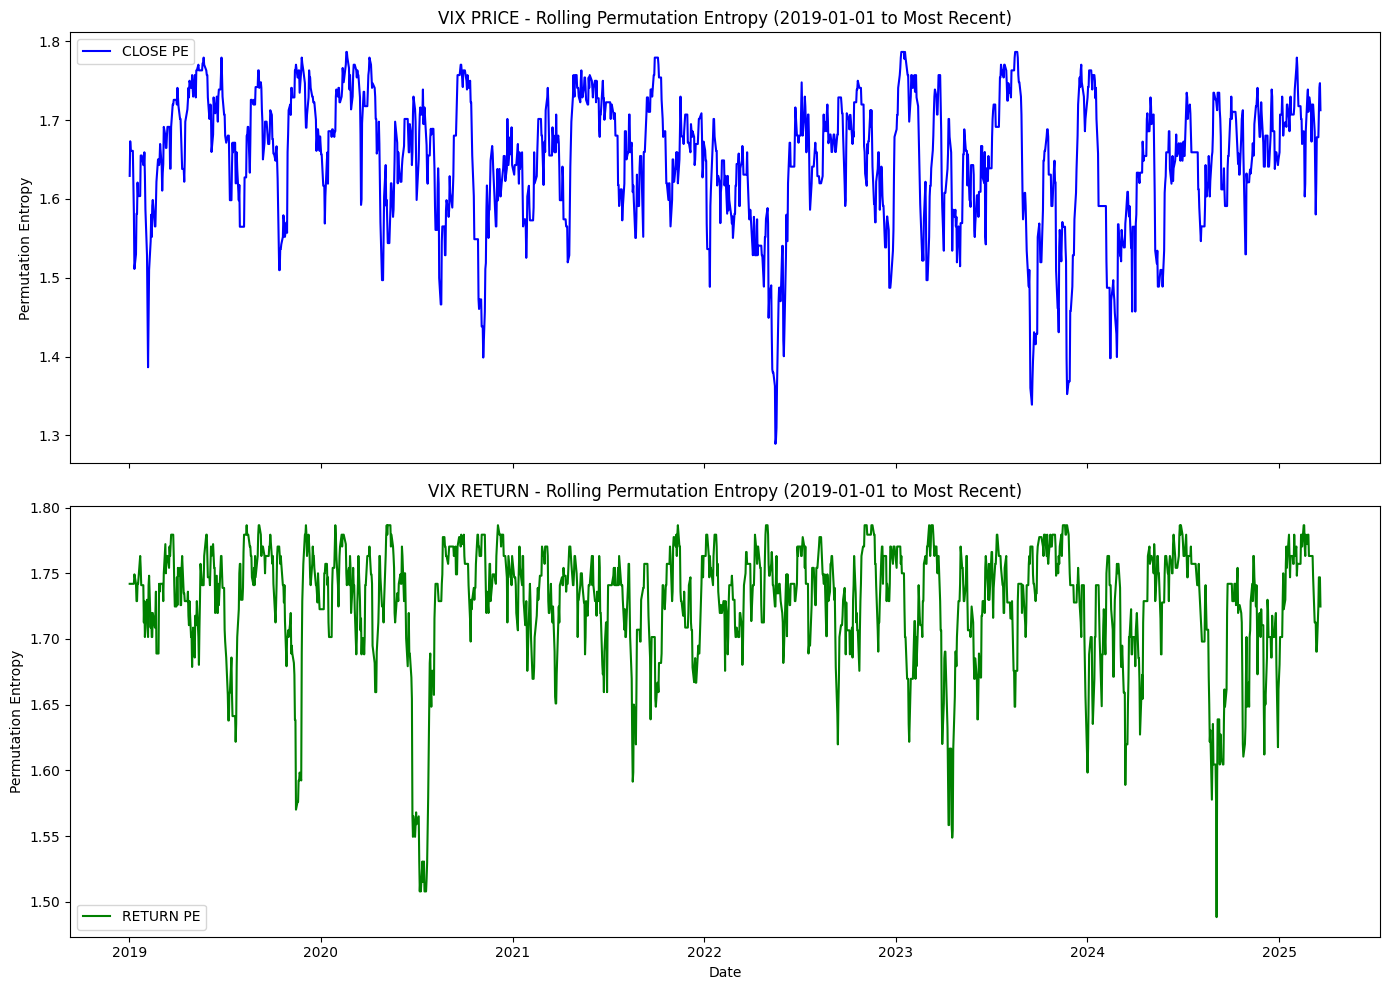

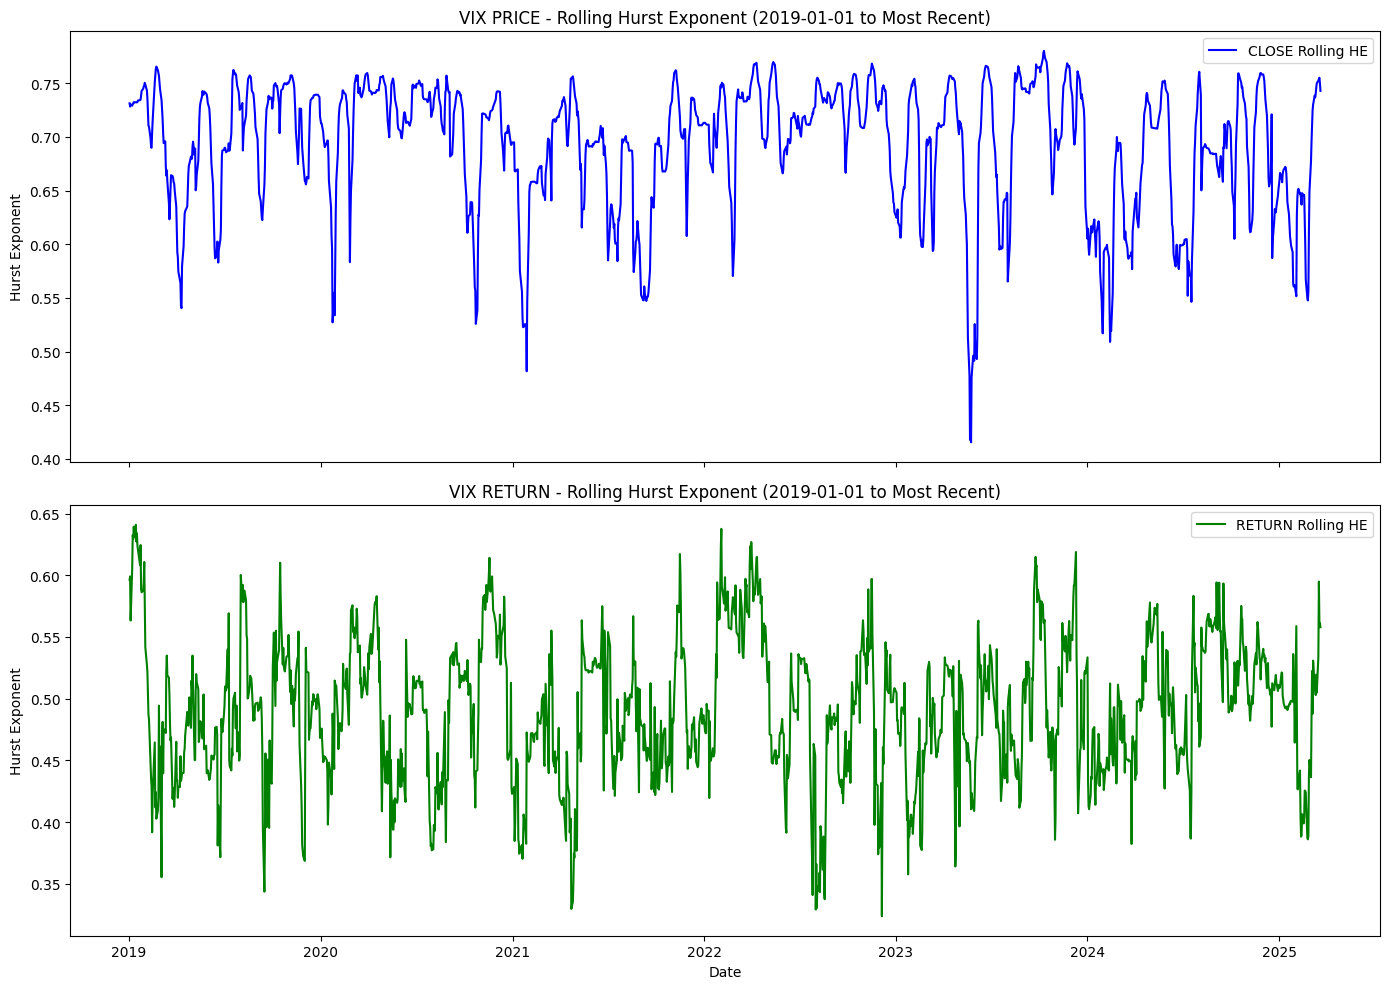

In [5]:
# ============================
# PLOTTING FOR EACH PAIR (RECENT)
# ============================

df_recent = df.loc['2019-01-01':]

# VIX
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df_recent['CLOSE'], label='CLOSE', color='blue')
axes[0].set_title('VIX PRICE (2019-01-01 to Most Recent)')
axes[0].set_ylabel('CLOSE')
axes[0].legend()

axes[1].plot(df_recent['RETURN'], label='RETURN', color='green')
axes[1].set_title('VIX RETURN (2019-01-01 to Most Recent)')
axes[1].set_ylabel('Return (%)')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

# GARCH 
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df_recent['CLOSE_GARCH'], label='CLOSE GARCH', color='blue')
axes[0].set_title('VIX PRICE - GARCH Conditional Volatility (2019-01-01 to Most Recent)')
axes[0].set_ylabel('Conditional Volatility')
axes[0].legend()

axes[1].plot(df_recent['RETURN_GARCH'], label='RETURN GARCH', color='green')
axes[1].set_title('VIX RETURN - GARCH Conditional Volatility (2019-01-01 to Most Recent)')
axes[1].set_ylabel('Conditional Volatility')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

# Rolling Permutation Entropy
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df_recent['CLOSE_PE'], label='CLOSE PE', color='blue')
axes[0].set_title('VIX PRICE - Rolling Permutation Entropy (2019-01-01 to Most Recent)')
axes[0].set_ylabel('Permutation Entropy')
axes[0].legend()

axes[1].plot(df_recent['RETURN_PE'], label='RETURN PE', color='green')
axes[1].set_title('VIX RETURN - Rolling Permutation Entropy (2019-01-01 to Most Recent)')
axes[1].set_ylabel('Permutation Entropy')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

# Rolling Hurst Exponent (R/S)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df_recent['CLOSE_HE'], label='CLOSE Rolling HE', color='blue')
axes[0].set_title('VIX PRICE - Rolling Hurst Exponent (2019-01-01 to Most Recent)')
axes[0].set_ylabel('Hurst Exponent')
axes[0].legend()

axes[1].plot(df_recent['RETURN_HE'], label='RETURN Rolling HE', color='green')
axes[1].set_title('VIX RETURN - Rolling Hurst Exponent (2019-01-01 to Most Recent)')
axes[1].set_ylabel('Hurst Exponent')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()



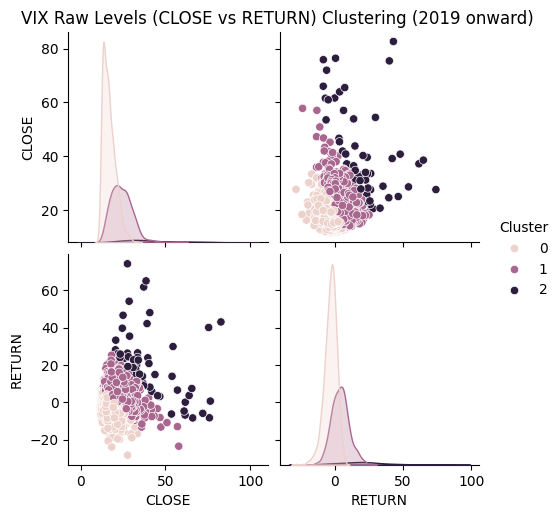

Summary Statistics for VIX Raw Levels:

Cluster 0 Summary:
            CLOSE      RETURN
count  959.000000  959.000000
mean    16.784692   -3.126513
std      3.732118    4.630583
min     11.540000  -28.156598
25%     13.740000   -5.701909
50%     16.030000   -2.540273
75%     19.080000   -0.055694
max     33.420000    7.404255

Cluster 1 Summary:
            CLOSE      RETURN
count  572.000000  572.000000
mean    24.171503    4.028907
std      6.394840    6.522629
min     13.600000  -23.373526
25%     19.327500   -0.471699
50%     23.335000    3.914678
75%     27.942500    7.815469
max     57.830000   25.206044

Cluster 2 Summary:
           CLOSE     RETURN
count  55.000000  55.000000
mean   41.476909  20.954550
std    16.621652  18.662867
min    20.550000  -8.277778
25%    28.415000   7.799701
50%    36.820000  19.212666
75%    53.720000  27.287809
max    82.690000  74.039067


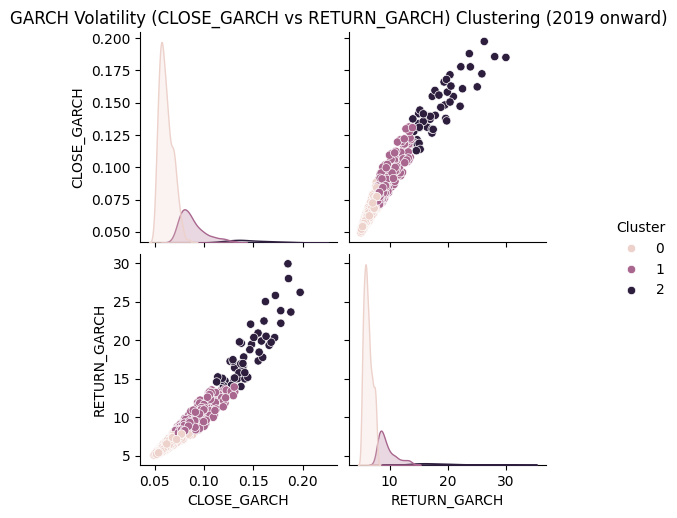

Summary Statistics for GARCH Volatility:

Cluster 0 Summary:
       CLOSE_GARCH  RETURN_GARCH
count  1213.000000   1213.000000
mean      0.061463      6.254002
std       0.006879      0.696827
min       0.049273      5.049751
25%       0.056118      5.704373
50%       0.060089      6.119817
75%       0.066198      6.750203
max       0.088441      7.856911

Cluster 1 Summary:
       CLOSE_GARCH  RETURN_GARCH
count   322.000000    322.000000
mean      0.088174      9.495132
std       0.013080      1.497912
min       0.069199      7.876724
25%       0.078647      8.360443
50%       0.084820      8.947116
75%       0.094178     10.231992
max       0.131177     13.916709

Cluster 2 Summary:
       CLOSE_GARCH  RETURN_GARCH
count    51.000000     51.000000
mean      0.146226     18.478655
std       0.020751      3.922394
min       0.112860     13.979654
25%       0.130761     15.114978
50%       0.140258     17.313805
75%       0.160145     20.356101
max       0.197397     29.955779


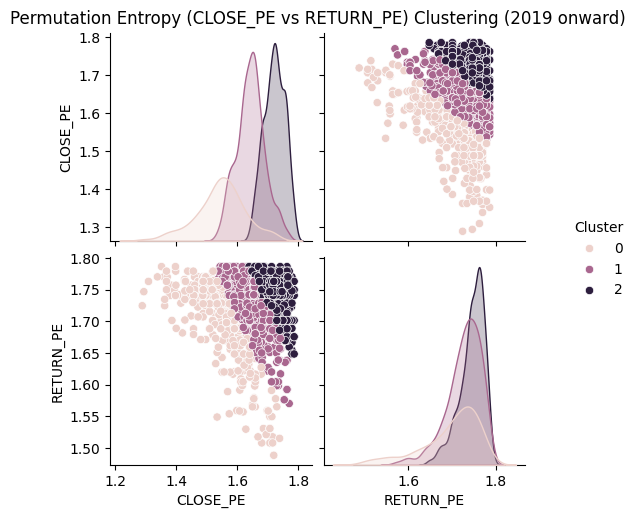

Summary Statistics for Permutation Entropy:

Cluster 0 Summary:
         CLOSE_PE   RETURN_PE
count  360.000000  360.000000
mean     1.546220    1.697360
std      0.080429    0.065017
min      1.289170    1.488423
25%      1.496875    1.667039
50%      1.550466    1.712569
75%      1.590952    1.741956
max      1.738844    1.786522

Cluster 1 Summary:
         CLOSE_PE   RETURN_PE
count  648.000000  648.000000
mean     1.643700    1.727210
std      0.045419    0.039796
min      1.528522    1.570193
25%      1.617056    1.706589
50%      1.642935    1.734765
75%      1.671286    1.757135
max      1.770307    1.786522

Cluster 2 Summary:
         CLOSE_PE   RETURN_PE
count  578.000000  578.000000
mean     1.721221    1.745766
std      0.033392    0.027868
min      1.638855    1.648451
25%      1.698029    1.728784
50%      1.722629    1.749944
75%      1.748111    1.763115
max      1.786522    1.786522


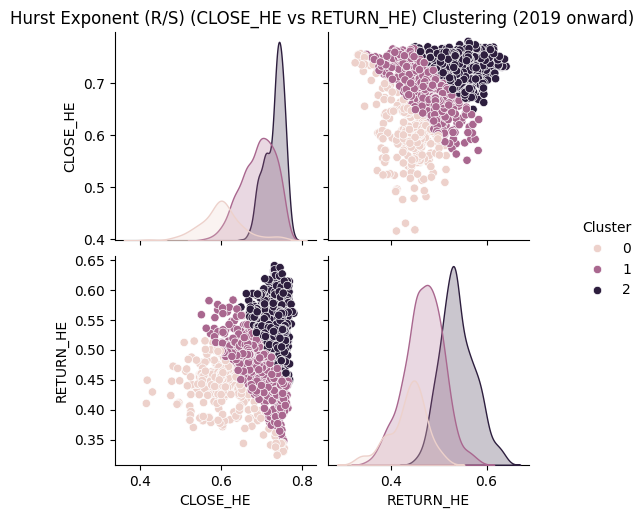

Summary Statistics for Hurst Exponent (R/S):

Cluster 0 Summary:
         CLOSE_HE   RETURN_HE
count  261.000000  261.000000
mean     0.600698    0.434740
std      0.056832    0.038638
min      0.415498    0.323692
25%      0.570800    0.413223
50%      0.599155    0.440634
75%      0.623077    0.459222
max      0.756336    0.515068

Cluster 1 Summary:
         CLOSE_HE   RETURN_HE
count  701.000000  701.000000
mean     0.692024    0.468110
std      0.041537    0.040182
min      0.551534    0.347697
25%      0.663077    0.443509
50%      0.695903    0.470789
75%      0.725447    0.495723
max      0.765839    0.583343

Cluster 2 Summary:
         CLOSE_HE   RETURN_HE
count  624.000000  624.000000
mean     0.731770    0.538476
std      0.023835    0.035900
min      0.649373    0.447292
25%      0.713609    0.513838
50%      0.737456    0.534388
75%      0.749742    0.562367
max      0.780096    0.640918
All analyses complete.


In [6]:
# ============================
# PLOTTING & CLUSTERING FOR EACH PAIR
# ============================

def plot_cluster_summary(df, col1, col2, title_prefix):
    missing = [col for col in [col1, col2] if col not in df.columns]
    if missing:
        print(f"Columns {missing} are missing from the DataFrame; skipping {title_prefix}.")
        return
    
    # Filter for recent data
    df_recent = df.loc['2019-01-01':, [col1, col2]].dropna().copy()
    # Compute the joint series (mean of the two columns)
    joint_series = df_recent.mean(axis=1)
    joint_series.name = f"{col1}_{col2}_mean"
    # Cluster the joint series
    clusters = kmeans_cluster(joint_series, n_clusters=3)
    clusters_bin = reorder_clusters(joint_series, clusters)
    df_recent['Cluster'] = clusters_bin

    sns.pairplot(df_recent, hue='Cluster', diag_kind='kde')
    plt.suptitle(f"{title_prefix} ({col1} vs {col2}) Clustering (2019 onward)", y=1.02)
    plt.show()

    print(f"Summary Statistics for {title_prefix}:")
    for clust in sorted(df_recent['Cluster'].unique()):
        print(f"\nCluster {clust} Summary:")
        print(df_recent[df_recent['Cluster'] == clust][[col1, col2]].describe())

plot_cluster_summary(df, 'CLOSE', 'RETURN', 'VIX Raw Levels')
plot_cluster_summary(df, 'CLOSE_GARCH', 'RETURN_GARCH', 'GARCH Volatility')
plot_cluster_summary(df, 'CLOSE_PE', 'RETURN_PE', 'Permutation Entropy')
plot_cluster_summary(df, 'CLOSE_HE', 'RETURN_HE', 'Hurst Exponent (R/S)')

print("All analyses complete.")


In [7]:
# # ============================================
# # 20-DAY MOVING AVERAGE AND KMEANS CLUSTERING
# # ============================================

# # For VIX_MA_20
# ma20_clusters = kmeans_cluster(df['VIX_MA_20'], n_clusters=3)
# df.loc[ma20_clusters.dropna().index, 'KMEANS_20_BIN'] = reorder_clusters(df['VIX_MA_20'], ma20_clusters)


# # Winsorize the VIX CLOSE values at 35 cap
# df['CLOSE'] = np.where(df['CLOSE'] > 35, 35, df['CLOSE'])

# # Compute the 20-day moving average of VIX CLOSE
# df['VIX_MA_20'] = df['CLOSE'].rolling(window=20).mean()

# # K-Means clusters 
# ma_series = df['VIX_MA_20'].dropna().copy()
# ma_series.name = 'VIX_MA_20'
# clusters = kmeans_cluster(ma_series, n_clusters=3)
# clusters_bin = reorder_clusters(ma_series, clusters)

# # Save Cluster bins to original DataFrame
# df.loc[ma_series.index, 'KMEANS_20_BIN'] = clusters_bin

# # Summary statistics
# print("Summary Statistics for KMeans Clusters on VIX 20-Day MA (Full Period):")
# for clust in sorted(df['KMEANS_20_BIN'].dropna().unique()):
#     print(f"\nCluster {clust} Summary:")
#     print(df[df['KMEANS_20_BIN'] == clust]['VIX_MA_20'].describe())

# # Plotting.
# df_plot = df.loc['2019-01-01':].copy()

# fig, ax = plt.subplots(figsize=(14, 6))
# ax.plot(df_plot.index, df_plot['VIX_MA_20'], color='purple', label='20-Day MA')


# ax.scatter(df_plot.index, df_plot['VIX_MA_20'], 
#            c=df_plot['KMEANS_20_BIN'], cmap='Set1', s=50, edgecolor='k')

# ax.set_title('20-Day Moving Average of VIX Raw CLOSE (2019 to Most Recent)')
# ax.set_ylabel('VIX 20-Day MA')
# ax.set_xlabel('Date')
# ax.legend()
# ax.grid(True)

# plt.tight_layout()
# plt.show()

In [8]:
# =============================
# SAVE RESULTS
# =============================

cols_to_keep = ['DATE',
    'CLOSE', 'RETURN', 
    'KMEANS_BIN_CLOSE', 
    'KMEANS_RETURN_BIN', 
    'VIX_MA_20', 'KMEANS_20_BIN', 
    'KMEANS_RETURN_GARCH', 'KMEANS_RETURN_GARCH_BIN',
    'KMEANS_RETURN_PE', 'KMEANS_RETURN_PE_BIN', 
    'KMEANS_RETURN_HE', 'KMEANS_RETURN_HE_BIN',
    'KMEANS_CLOSE_GARCH', 'KMEANS_CLOSE_GARCH_BIN',
    'KMEANS_CLOSE_PE', 'KMEANS_CLOSE_PE_BIN', 
    'KMEANS_CLOSE_HE', 'KMEANS_CLOSE_HE_BIN'
]

existing_cols = [col for col in cols_to_keep if col in df.columns]

df_out = df[existing_cols].dropna().copy()
df_out.reset_index(inplace=True)

print(df_out.tail(10))

output_file = 'VIX_Analysis.csv'
df_out.to_csv(output_file, index=False)

print(f"VIX analysis completed. Results saved to {output_file}")

           DATE  CLOSE     RETURN  KMEANS_BIN_CLOSE  KMEANS_RETURN_BIN  \
8850 2025-03-10  27.86  19.212666               1.0                2.0   
8851 2025-03-11  26.92  -3.374013               1.0                0.0   
8852 2025-03-12  24.23  -9.992571               1.0                0.0   
8853 2025-03-13  24.66   1.774660               1.0                1.0   
8854 2025-03-14  21.77 -11.719384               1.0                0.0   
8855 2025-03-17  20.51  -5.787781               1.0                0.0   
8856 2025-03-18  21.70   5.802048               1.0                1.0   
8857 2025-03-19  19.90  -8.294931               1.0                0.0   
8858 2025-03-20  19.80  -0.502513               1.0                1.0   
8859 2025-03-21  19.28  -2.626263               0.0                0.0   

      KMEANS_RETURN_GARCH  KMEANS_RETURN_GARCH_BIN  KMEANS_RETURN_PE  \
8850                  2.0                      1.0               0.0   
8851                  2.0                

In [9]:
# ================================
# Variance Inflation Factors Test
# ================================

df = pd.read_csv("VIX_Analysis.csv", parse_dates=["DATE"])

vif_features = [
    'KMEANS_RETURN_GARCH', 'KMEANS_RETURN_PE', 'KMEANS_RETURN_HE',
    'KMEANS_CLOSE_GARCH', 'KMEANS_CLOSE_PE', 'KMEANS_CLOSE_HE',
    'RETURN', 'CLOSE'
]

X = df[vif_features].copy()
# X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# vif_data = vif_data[vif_data["feature"] != "const"]

print("Variance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
               feature       VIF
0  KMEANS_RETURN_GARCH  2.921364
1     KMEANS_RETURN_PE  2.185396
2     KMEANS_RETURN_HE  1.891644
3   KMEANS_CLOSE_GARCH  3.188834
4      KMEANS_CLOSE_PE  3.321504
5      KMEANS_CLOSE_HE  1.716941
6               RETURN  1.016708
7                CLOSE  4.357702


In [10]:
# ============================
# Johansen Cointegration
# ============================

df = pd.read_csv("VIX_Analysis.csv", parse_dates=["DATE"])

vif_features = [
    'KMEANS_RETURN_GARCH', 'KMEANS_RETURN_PE', 'KMEANS_RETURN_HE',
    'KMEANS_CLOSE_GARCH', 'KMEANS_CLOSE_PE', 'KMEANS_CLOSE_HE',
    'RETURN', 'CLOSE'
]

# Create a DataFrame for the Johansen test 
df_cointegration = df[vif_features].dropna()

johansen_test = coint_johansen(df_cointegration, det_order=0, k_ar_diff=1)
# - det_order=0 specifies no deterministic trend 
# - k_ar_diff=1 uses one lag difference 

# Print the trace statistics and critical values
print("Johansen Cointegration Test Trace Statistics:")
print(johansen_test.lr1)  

print("\nCritical Values (at 90%, 95%, and 99% levels):")
print(johansen_test.cvt)  

# Print the eigenvalues 
print("\nEigenvalues:")
print(johansen_test.eig)

Johansen Cointegration Test Trace Statistics:
[14430.36571243  7460.04052573  4792.53358909  3608.09553209
  2511.25492501  1581.76318284   782.06305184    68.86001795]

Critical Values (at 90%, 95%, and 99% levels):
[[153.6341 159.529  171.0905]
 [120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]

Eigenvalues:
[0.5447443  0.26002657 0.12515971 0.11646543 0.09961467 0.08632467
 0.07735906 0.00774363]


Frequency of Return Regime Combinations:
Return_Composite
0.0_0.0_0.0    1226
0.0_0.0_1.0     769
0.0_0.0_2.0     715
0.0_1.0_0.0     256
0.0_1.0_1.0     169
0.0_1.0_2.0     142
0.0_2.0_0.0    1734
0.0_2.0_1.0    1192
0.0_2.0_2.0    1032
1.0_0.0_0.0      40
1.0_0.0_1.0      15
1.0_0.0_2.0      29
1.0_1.0_0.0       5
1.0_1.0_1.0       3
1.0_1.0_2.0      12
1.0_2.0_0.0      28
1.0_2.0_1.0       6
1.0_2.0_2.0      19
2.0_0.0_0.0     248
2.0_0.0_1.0     158
2.0_0.0_2.0     178
2.0_1.0_0.0      50
2.0_1.0_1.0      12
2.0_1.0_2.0      33
2.0_2.0_0.0     372
2.0_2.0_1.0     200
2.0_2.0_2.0     217
Name: count, dtype: int64


C:\Users\npwol\AppData\Local\Temp\ipykernel_56784\3358629734.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=return_freq.index, y=return_freq.values, palette="viridis")


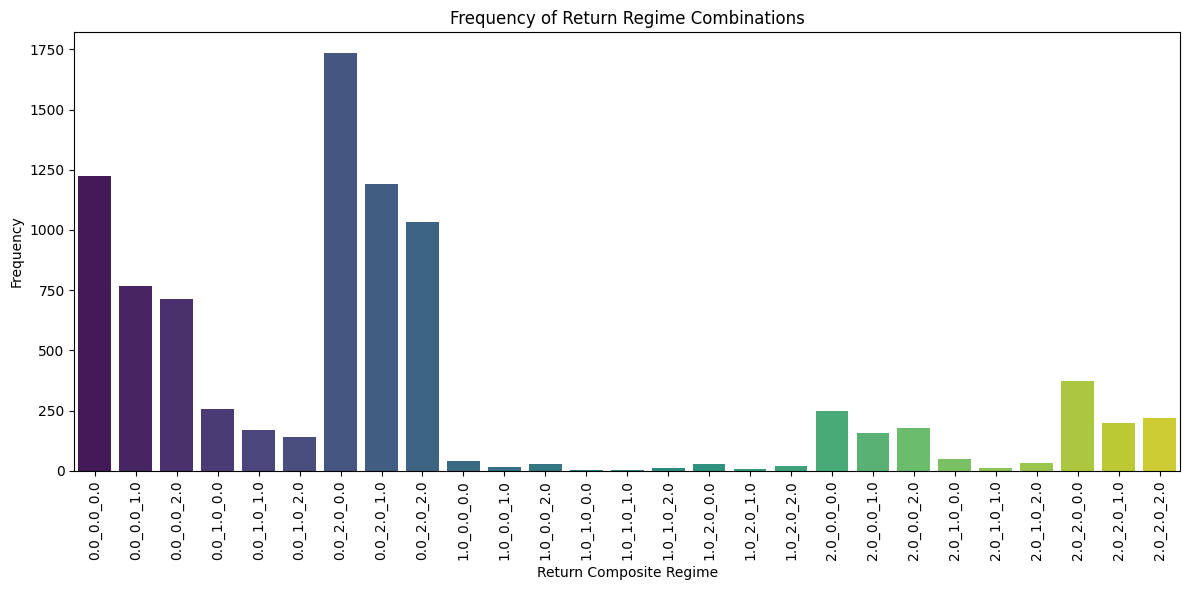


Frequency of Close Regime Combinations:
Close_Composite
0.0_0.0_0.0     559
0.0_0.0_1.0      88
0.0_0.0_2.0     295
0.0_1.0_0.0    1456
0.0_1.0_1.0     576
0.0_1.0_2.0    1293
0.0_2.0_0.0    1231
0.0_2.0_1.0     401
0.0_2.0_2.0     697
1.0_0.0_0.0       9
1.0_0.0_1.0       3
1.0_0.0_2.0      13
1.0_1.0_0.0      61
1.0_1.0_1.0      28
1.0_1.0_2.0      33
1.0_2.0_0.0      77
1.0_2.0_1.0      10
1.0_2.0_2.0      62
2.0_0.0_0.0     151
2.0_0.0_1.0      30
2.0_0.0_2.0      58
2.0_1.0_0.0     425
2.0_1.0_1.0     169
2.0_1.0_2.0     410
2.0_2.0_0.0     371
2.0_2.0_1.0      97
2.0_2.0_2.0     257
Name: count, dtype: int64


C:\Users\npwol\AppData\Local\Temp\ipykernel_56784\3358629734.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=close_freq.index, y=close_freq.values, palette="viridis")


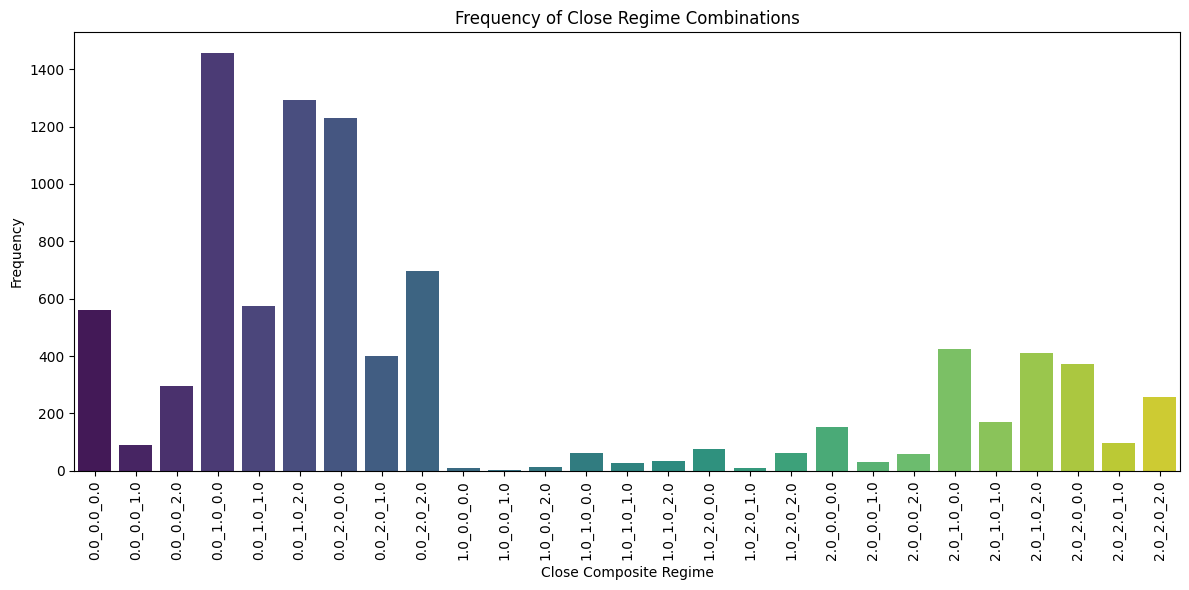

In [11]:
# ============================
# CROSS VARIABLE FREQUENCY
# ============================

# Create a composite variable for the return-related regime factors
return_regime_cols = ['KMEANS_RETURN_GARCH', 'KMEANS_RETURN_PE', 'KMEANS_RETURN_HE']
df['Return_Composite'] = df[return_regime_cols].astype(str).agg('_'.join, axis=1)

# Create a composite variable for the close-related regime factors
close_regime_cols = ['KMEANS_CLOSE_GARCH', 'KMEANS_CLOSE_PE', 'KMEANS_CLOSE_HE']
df['Close_Composite'] = df[close_regime_cols].astype(str).agg('_'.join, axis=1)

# Frequency table for the return regime combinations
print("Frequency of Return Regime Combinations:")
return_freq = df['Return_Composite'].value_counts().sort_index()
print(return_freq)

# Bar plot for the return composite regimes
plt.figure(figsize=(12,6))
sns.barplot(x=return_freq.index, y=return_freq.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Return Composite Regime")
plt.ylabel("Frequency")
plt.title("Frequency of Return Regime Combinations")
plt.tight_layout()
plt.show()

# Frequency table for the close regime combinations
print("\nFrequency of Close Regime Combinations:")
close_freq = df['Close_Composite'].value_counts().sort_index()
print(close_freq)

# Bar plot for the close composite regimes
plt.figure(figsize=(12,6))
sns.barplot(x=close_freq.index, y=close_freq.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Close Composite Regime")
plt.ylabel("Frequency")
plt.title("Frequency of Close Regime Combinations")
plt.tight_layout()
plt.show()


Frequency of Return Regime Combinations:
Return_Composite
0.0_0.0_0.0    1226
0.0_0.0_1.0     769
0.0_0.0_2.0     715
0.0_1.0_0.0     256
0.0_1.0_1.0     169
0.0_1.0_2.0     142
0.0_2.0_0.0    1734
0.0_2.0_1.0    1192
0.0_2.0_2.0    1032
1.0_0.0_0.0      40
1.0_0.0_1.0      15
1.0_0.0_2.0      29
1.0_1.0_0.0       5
1.0_1.0_1.0       3
1.0_1.0_2.0      12
1.0_2.0_0.0      28
1.0_2.0_1.0       6
1.0_2.0_2.0      19
2.0_0.0_0.0     248
2.0_0.0_1.0     158
2.0_0.0_2.0     178
2.0_1.0_0.0      50
2.0_1.0_1.0      12
2.0_1.0_2.0      33
2.0_2.0_0.0     372
2.0_2.0_1.0     200
2.0_2.0_2.0     217
Name: count, dtype: int64


C:\Users\npwol\AppData\Local\Temp\ipykernel_56784\1515320816.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=return_freq.index, y=return_freq.values, palette=bar_palette_return)


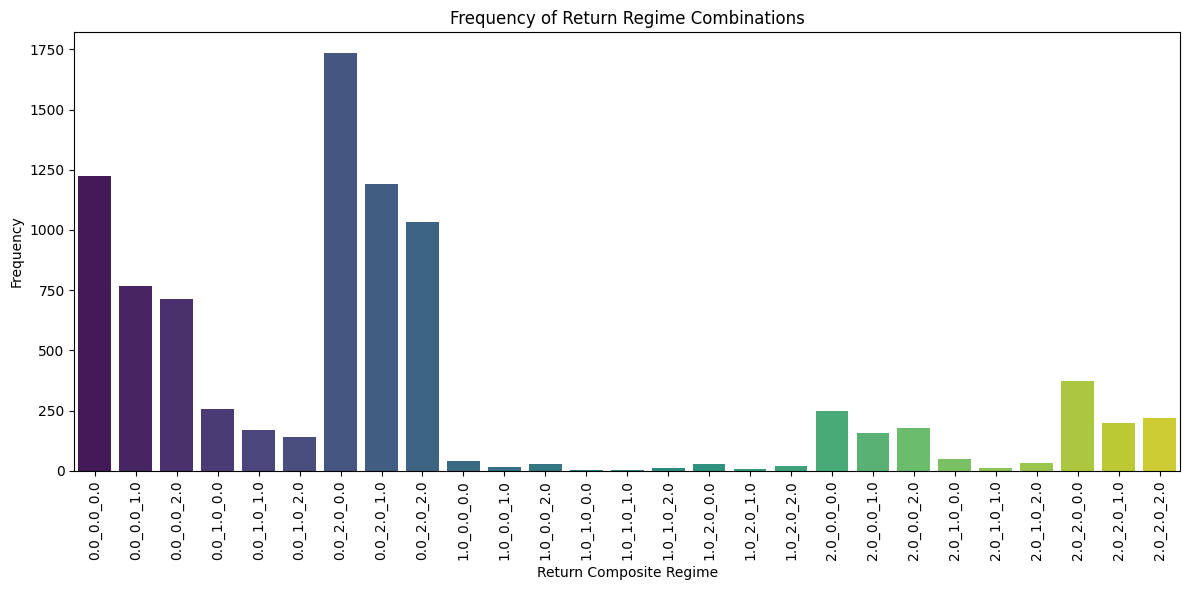

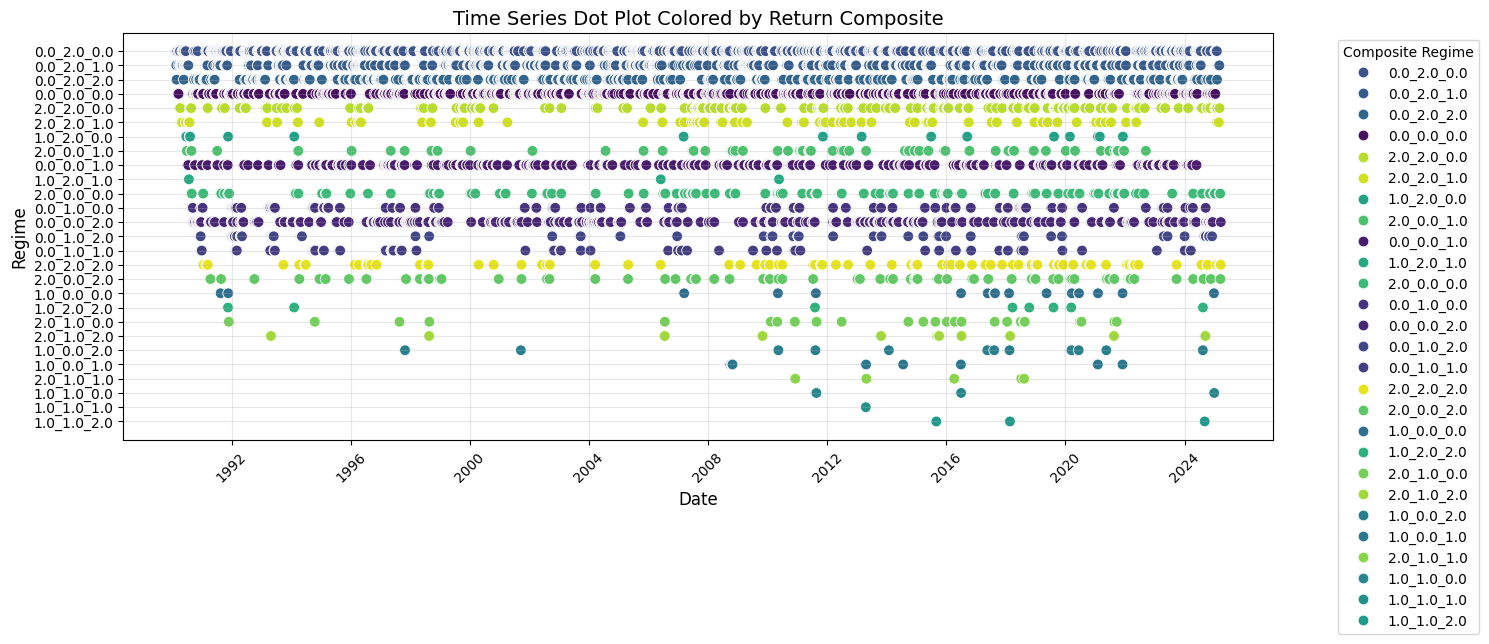

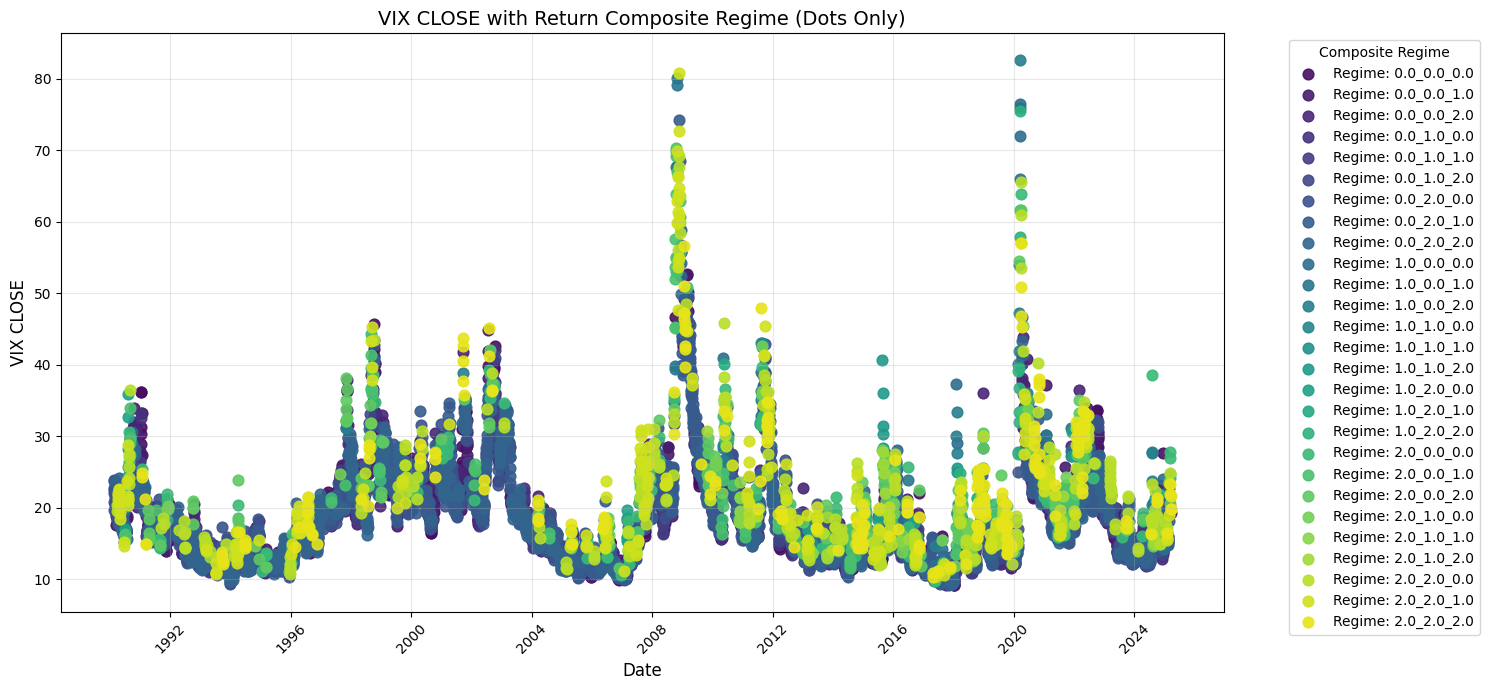

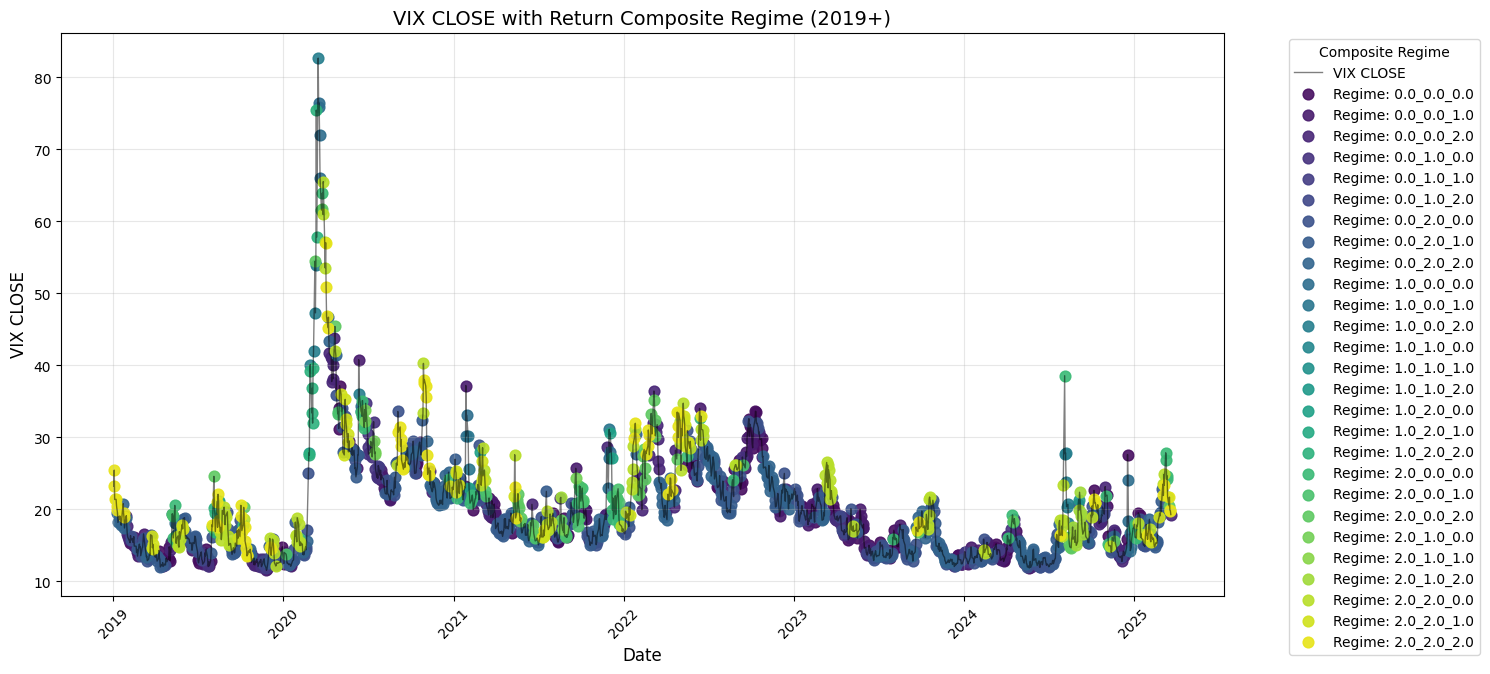

In [12]:
unique_return_regimes = sorted(df['Return_Composite'].unique())

#  Use consistent colors
viridis_palette = sns.color_palette("viridis", len(unique_return_regimes))
color_dict = dict(zip(unique_return_regimes, viridis_palette))

# Frequencies
return_freq = df['Return_Composite'].value_counts().sort_index()
print("Frequency of Return Regime Combinations:")
print(return_freq)

# Match colors
bar_palette_return = [color_dict[r] for r in return_freq.index]

plt.figure(figsize=(12,6))
sns.barplot(x=return_freq.index, y=return_freq.values, palette=bar_palette_return)
plt.xticks(rotation=90)
plt.xlabel("Return Composite Regime")
plt.ylabel("Frequency")
plt.title("Frequency of Return Regime Combinations")
plt.tight_layout()
plt.show()

# Dates
df['DATE'] = pd.to_datetime(df['DATE'])
df.sort_values('DATE', inplace=True)

plt.figure(figsize=(15,6))
sns.scatterplot(
    data=df,
    x='DATE',
    y='Return_Composite',
    hue='Return_Composite',
    palette=color_dict,  
    s=60,
    legend='full'
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Regime", fontsize=12)
plt.title("Time Series Dot Plot Colored by Return Composite", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Composite Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

# Overlaid with VIX
plt.figure(figsize=(15,7))
for regime in unique_return_regimes:
    regime_df = df[df['Return_Composite'] == regime]
    plt.scatter(
        regime_df['DATE'],
        regime_df['CLOSE'],
        color=color_dict[regime],
        s=60,
        label=f'Regime: {regime}',
        alpha=0.9
    )
plt.xlabel('Date', fontsize=12)
plt.ylabel('VIX CLOSE', fontsize=12)
plt.title('VIX CLOSE with Return Composite Regime (Dots Only)', fontsize=14)
plt.legend(title='Composite Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df_recent = df[df['DATE'] >= '2019-01-01']

plt.figure(figsize=(15, 7))

plt.plot(df_recent['DATE'], df_recent['CLOSE'], color='black', linewidth=1, alpha=0.5, label='VIX CLOSE')


for regime in unique_return_regimes:
    regime_df = df_recent[df_recent['Return_Composite'] == regime]
    plt.scatter(
        regime_df['DATE'],
        regime_df['CLOSE'],
        color=color_dict[regime],
        s=60,
        label=f'Regime: {regime}',
        alpha=0.9
    )

plt.xlabel('Date', fontsize=12)
plt.ylabel('VIX CLOSE', fontsize=12)
plt.title('VIX CLOSE with Return Composite Regime (2019+)', fontsize=14)
plt.legend(title='Composite Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Frequency of Close Regime Combinations:
Close_Composite
0.0_0.0_0.0     559
0.0_0.0_1.0      88
0.0_0.0_2.0     295
0.0_1.0_0.0    1456
0.0_1.0_1.0     576
0.0_1.0_2.0    1293
0.0_2.0_0.0    1231
0.0_2.0_1.0     401
0.0_2.0_2.0     697
1.0_0.0_0.0       9
1.0_0.0_1.0       3
1.0_0.0_2.0      13
1.0_1.0_0.0      61
1.0_1.0_1.0      28
1.0_1.0_2.0      33
1.0_2.0_0.0      77
1.0_2.0_1.0      10
1.0_2.0_2.0      62
2.0_0.0_0.0     151
2.0_0.0_1.0      30
2.0_0.0_2.0      58
2.0_1.0_0.0     425
2.0_1.0_1.0     169
2.0_1.0_2.0     410
2.0_2.0_0.0     371
2.0_2.0_1.0      97
2.0_2.0_2.0     257
Name: count, dtype: int64


C:\Users\npwol\AppData\Local\Temp\ipykernel_56784\1864325855.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=close_freq.index, y=close_freq.values, palette=bar_palette_close)


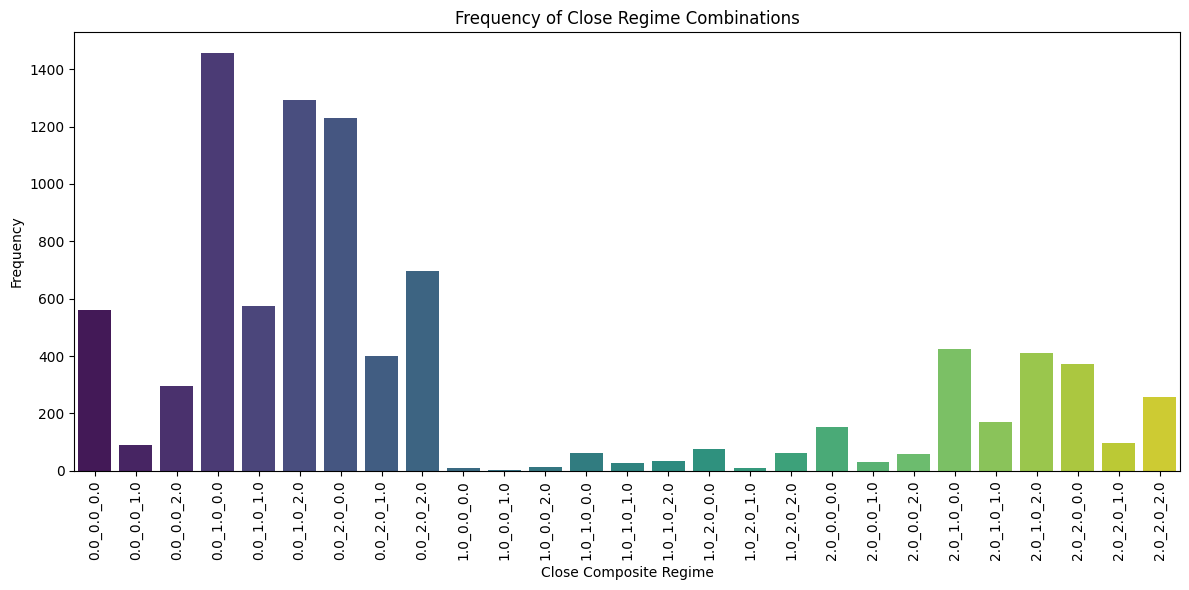

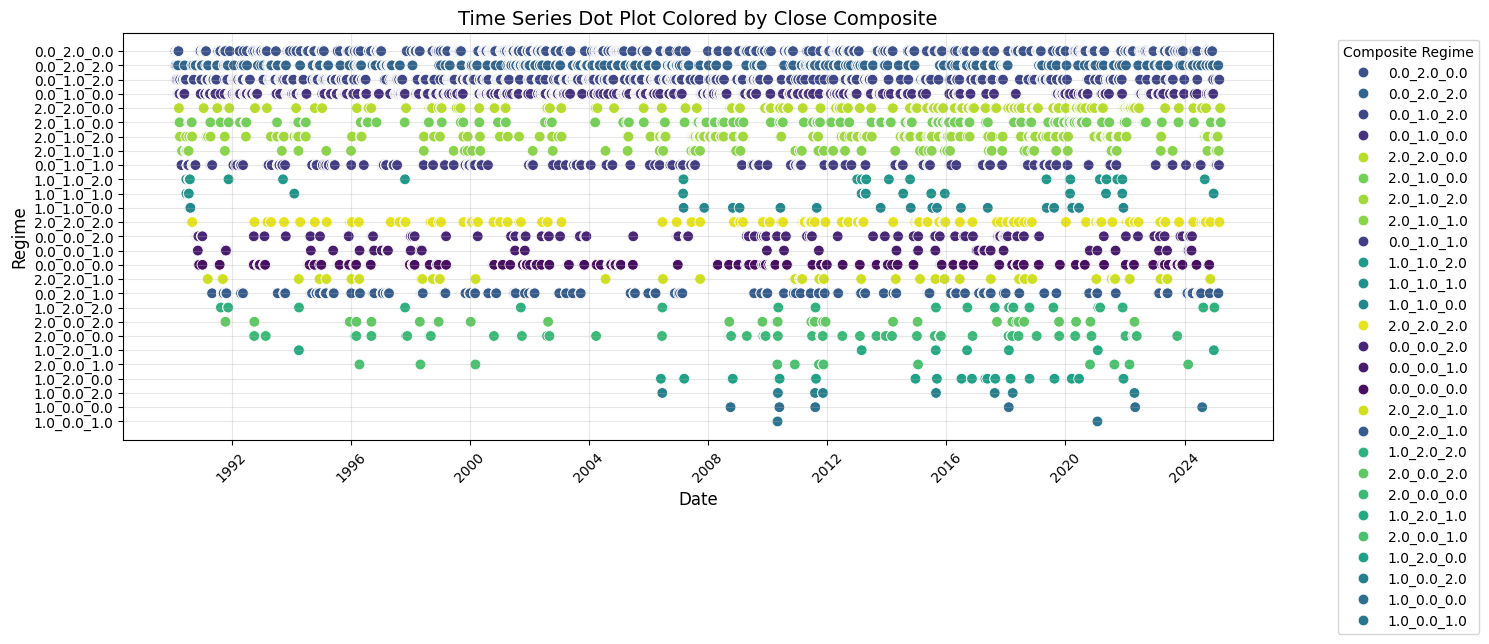

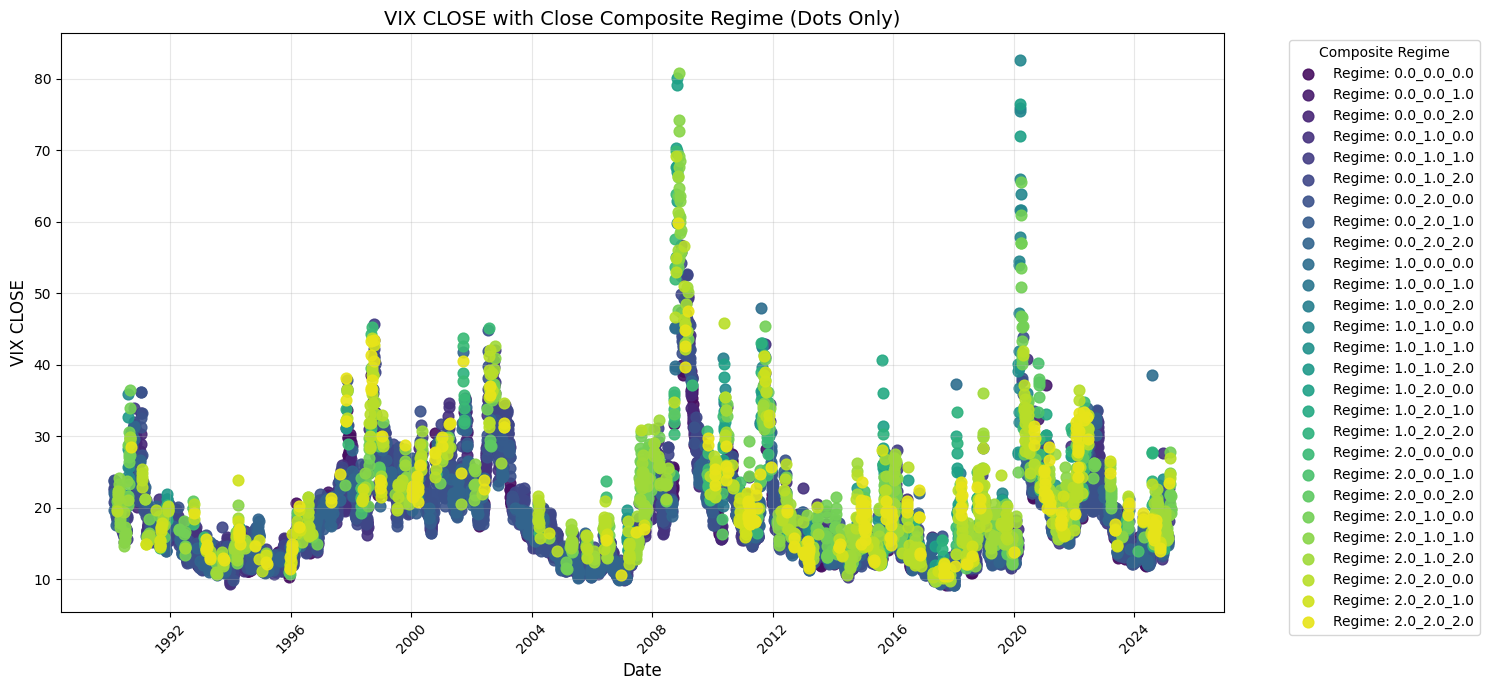

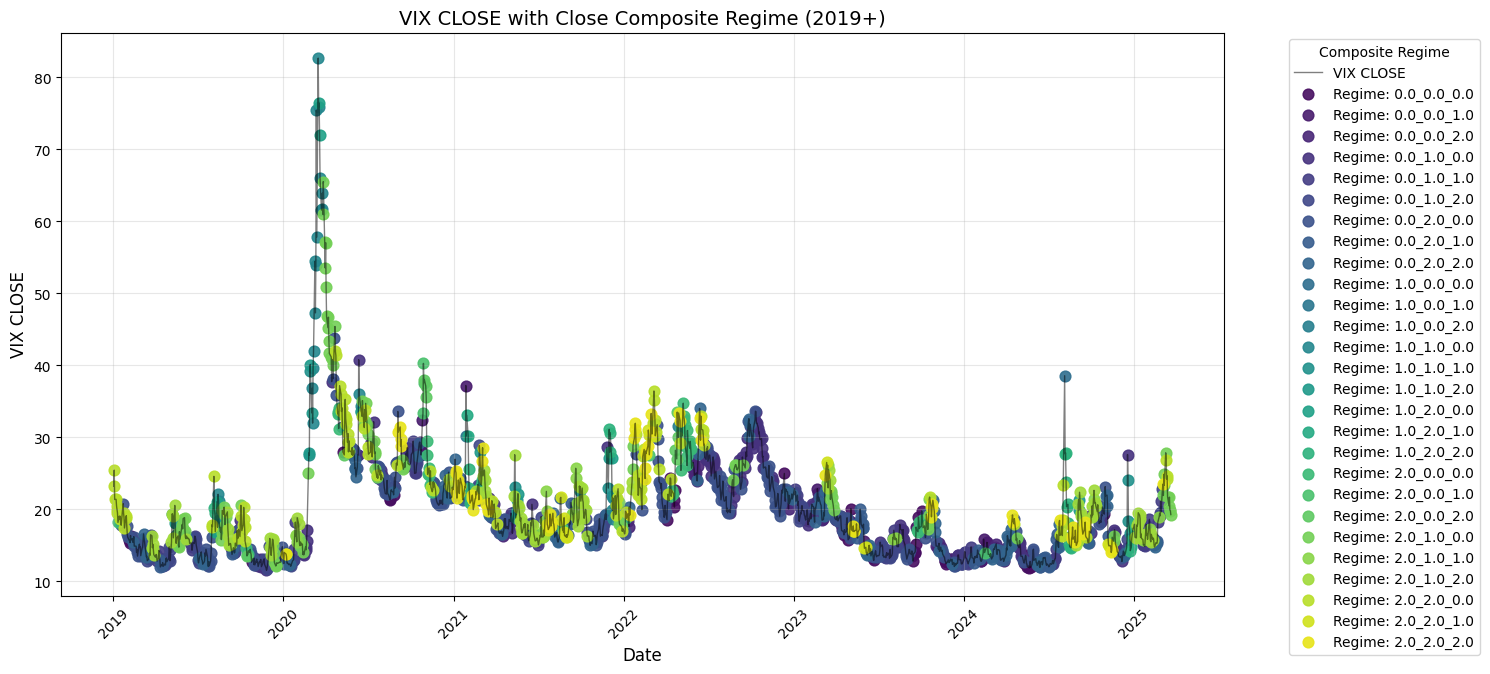

In [13]:
unique_close_regimes = sorted(df['Close_Composite'].unique())

viridis_palette_close = sns.color_palette("viridis", len(unique_close_regimes))
color_dict_close = dict(zip(unique_close_regimes, viridis_palette_close))

close_freq = df['Close_Composite'].value_counts().sort_index()
print("Frequency of Close Regime Combinations:")
print(close_freq)

bar_palette_close = [color_dict_close[r] for r in close_freq.index]

plt.figure(figsize=(12,6))
sns.barplot(x=close_freq.index, y=close_freq.values, palette=bar_palette_close)
plt.xticks(rotation=90)
plt.xlabel("Close Composite Regime")
plt.ylabel("Frequency")
plt.title("Frequency of Close Regime Combinations")
plt.tight_layout()
plt.show()

df['DATE'] = pd.to_datetime(df['DATE'])
df.sort_values('DATE', inplace=True)

plt.figure(figsize=(15,6))
sns.scatterplot(
    data=df,
    x='DATE',
    y='Close_Composite',
    hue='Close_Composite',
    palette=color_dict_close,  
    s=60,
    legend='full'
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Regime", fontsize=12)
plt.title("Time Series Dot Plot Colored by Close Composite", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Composite Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(15,7))

for regime in unique_close_regimes:
    regime_df = df[df['Close_Composite'] == regime]
    plt.scatter(
        regime_df['DATE'],
        regime_df['CLOSE'],
        color=color_dict_close[regime],
        s=60,
        label=f'Regime: {regime}',
        alpha=0.9
    )
plt.xlabel('Date', fontsize=12)
plt.ylabel('VIX CLOSE', fontsize=12)
plt.title('VIX CLOSE with Close Composite Regime (Dots Only)', fontsize=14)
plt.legend(title='Composite Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

df_recent = df[df['DATE'] >= '2019-01-01']

plt.figure(figsize=(15, 7))

plt.plot(df_recent['DATE'], df_recent['CLOSE'], color='black', linewidth=1, alpha=0.5, label='VIX CLOSE')

for regime in unique_close_regimes:
    regime_df = df_recent[df_recent['Close_Composite'] == regime]
    plt.scatter(
        regime_df['DATE'],
        regime_df['CLOSE'],
        color=color_dict_close[regime],
        s=60,
        label=f'Regime: {regime}',
        alpha=0.9
    )

plt.xlabel('Date', fontsize=12)
plt.ylabel('VIX CLOSE', fontsize=12)
plt.title('VIX CLOSE with Close Composite Regime (2019+)', fontsize=14)
plt.legend(title='Composite Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Markov Transition Matrix for Return Composite regimes:
             0.0_0.0_0.0  0.0_0.0_1.0  0.0_0.0_2.0  0.0_1.0_0.0  0.0_1.0_1.0  \
0.0_0.0_0.0     0.591354     0.101958     0.089723     0.024470     0.002447   
0.0_0.0_1.0     0.149545     0.600780     0.010403     0.011704     0.023407   
0.0_0.0_2.0     0.142857     0.008403     0.593838     0.007003     0.000000   
0.0_1.0_0.0     0.105469     0.035156     0.011719     0.585938     0.136719   
0.0_1.0_1.0     0.035503     0.142012     0.000000     0.177515     0.591716   
0.0_1.0_2.0     0.014085     0.014085     0.126761     0.133803     0.035211   
0.0_2.0_0.0     0.084775     0.014418     0.006920     0.000000     0.000000   
0.0_2.0_1.0     0.021812     0.063758     0.000839     0.000000     0.000000   
0.0_2.0_2.0     0.017442     0.000000     0.092054     0.000000     0.000000   
1.0_0.0_0.0     0.000000     0.000000     0.000000     0.000000     0.000000   
1.0_0.0_1.0     0.000000     0.000000     0.000000     0.000000 

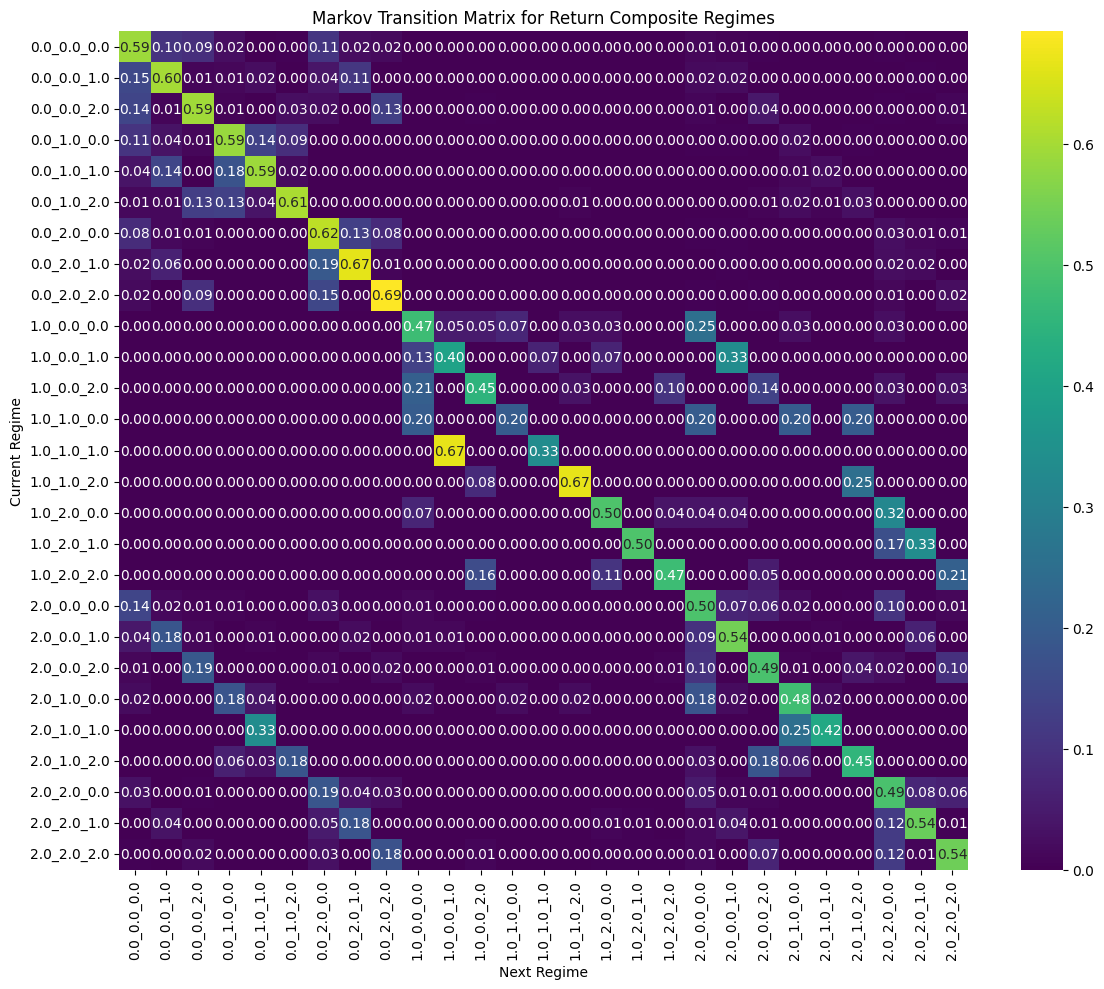

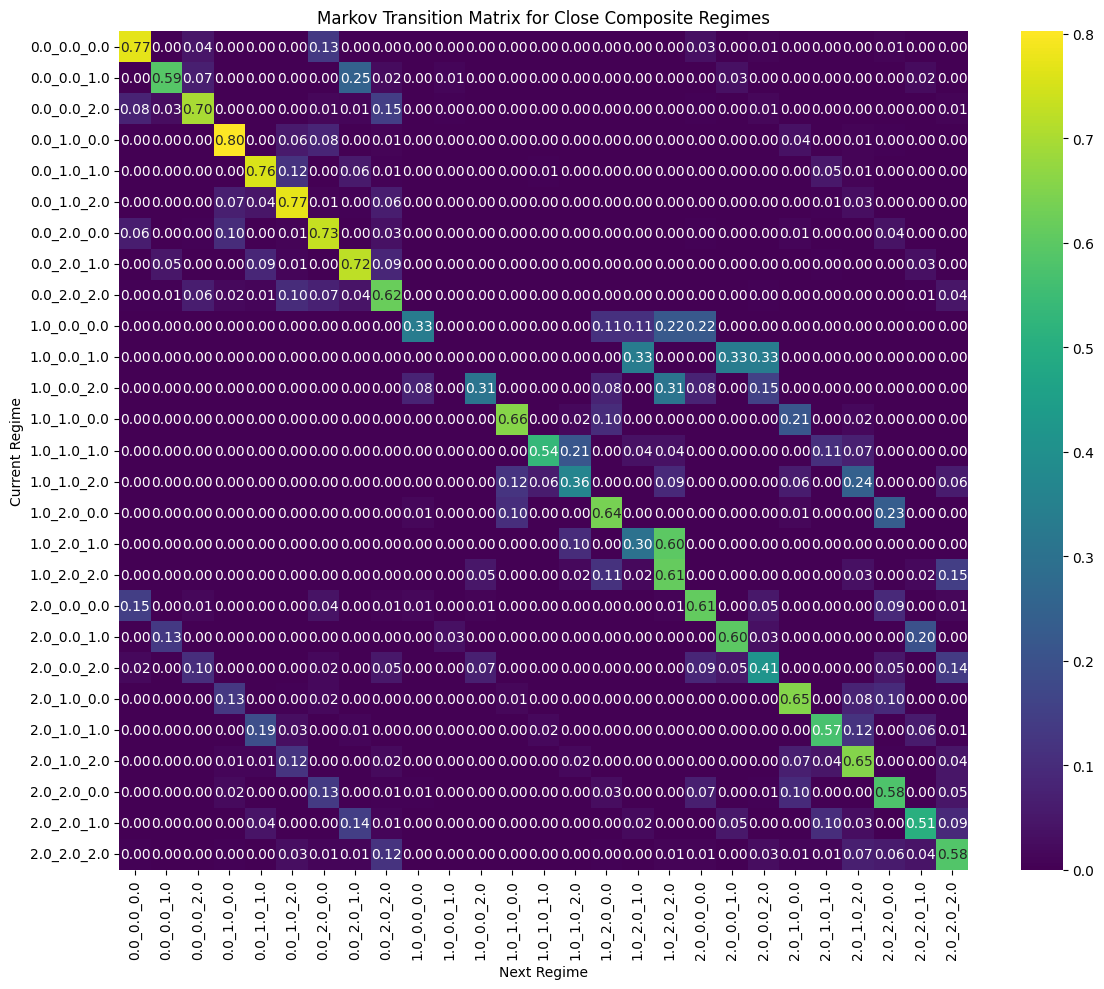

In [14]:
# =================================
# Markov Transition Matrix Analysis
# =================================

def markov_transition_matrix(regime_series):

    regime_series = regime_series.dropna().values
    unique_regimes = sorted(set(regime_series))
    transition_matrix = pd.DataFrame(0, index=unique_regimes, columns=unique_regimes, dtype=float)
    
    # Count regime transitions 
    for (current_regime, next_regime) in zip(regime_series[:-1], regime_series[1:]):
        transition_matrix.loc[current_regime, next_regime] += 1
        
    # COnvert countrs to probabilties
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    return transition_matrix

# Compute the transition matrices
trans_matrix_return = markov_transition_matrix(df['Return_Composite'])
trans_matrix_close = markov_transition_matrix(df['Close_Composite'])

# Print matrices 
print("\nMarkov Transition Matrix for Return Composite regimes:")
print(trans_matrix_return)
print("\nMarkov Transition Matrix for Close Composite regimes:")
print(trans_matrix_close)

# Plot the Transition Matrices as Heat Maps

# Heat map for Return Composites
plt.figure(figsize=(12, 10))
sns.heatmap(trans_matrix_return, annot=True, fmt=".2f", cmap="viridis")
plt.title("Markov Transition Matrix for Return Composite Regimes")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.tight_layout()
plt.show()

# Heat map for Close Composites
plt.figure(figsize=(12, 10))
sns.heatmap(trans_matrix_close, annot=True, fmt=".2f", cmap="viridis")
plt.title("Markov Transition Matrix for Close Composite Regimes")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.tight_layout()
plt.show()
